# What's new since last year's UGM?
## 2016 Edition

Not an exhaustive list, just some examples.

- [Drawing improvements](#Drawing-Improvements)
- [FPB Reader](#FPB-Reader)
- [New ChemicalReaction functionality](#New-Chemical-Reaction-Functionality)
- [Tuning substructure queries](#Tuning-Substructure-Queries)
- [Jupyter Interactivty](#Jupyter-Interactivity)


## KNIME Integration

- Initial support for KNIME's new (and still beta) streaming feature
- Support for Sereina's new conformation generation code (now used by default)
- RDKit Molecule Extractor node
- The usual bug fixes
- Development moved to github


## Drawing Improvements

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import AllChem
from IPython.display import SVG
def basicmoltosvg(mol,molSize=(450,200),drawer=None,**kwargs):
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mol,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

In [2]:
m = Chem.MolFromSmiles('CNC[C@H](O)c1ccc(O)c(O)c1') # epinephrine

What if we just generate coordinates and show the molecule?

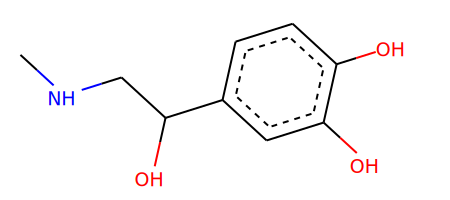

In [3]:
AllChem.Compute2DCoords(m)
basicmoltosvg(m)

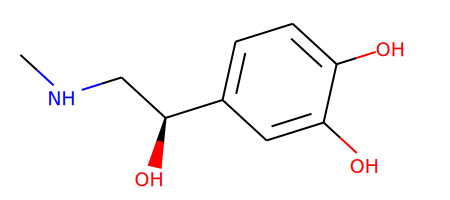

In [4]:
nm = rdMolDraw2D.PrepareMolForDrawing(m)
basicmoltosvg(nm)

In [5]:
rdMolDraw2D.PrepareMolForDrawing?

*Note*: if you just want to see a molecule in the notebook, you don't have to do all this work; the Jupyter integration does it for you:

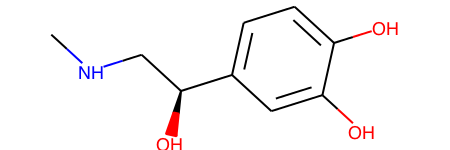

In [6]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
Chem.MolFromSmiles('CNC[C@H](O)c1ccc(O)c(O)c1') # epinephrine

MolsToGridImage now uses the new rendering code and supports SVG:

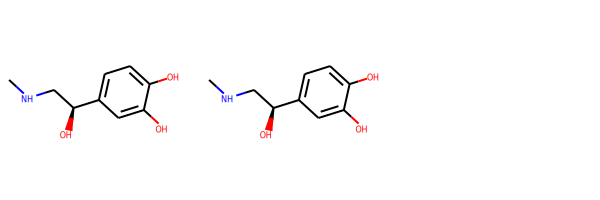

In [7]:
from rdkit.Chem import Draw
Draw.MolsToGridImage([m,m],useSVG=True)

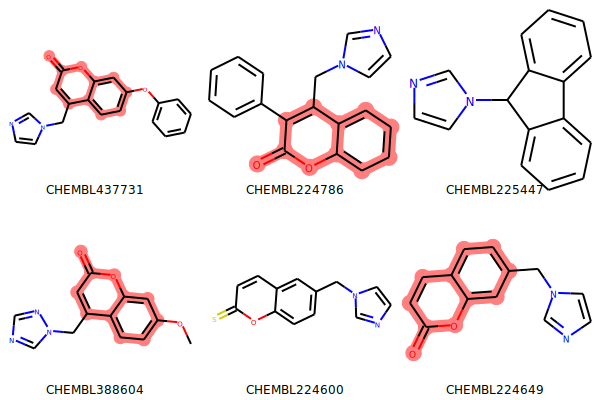

In [8]:
import pickle
d = pickle.load(open('./data/Target_no_65.pkl','rb'))  # this particular target is "Cytochrome P450 19A1 Homo sapiens"
entries = d[35328][:6]
mols = [Chem.MolFromSmiles(y) for x,y in entries]
nms = [x for x,y in entries]
p = Chem.MolFromSmiles('O=c1oc2ccccc2cc1')
matches=[x.GetSubstructMatch(p) for x in mols]
Draw.MolsToGridImage(mols,highlightAtomLists=matches,legends=nms,)

## FPB Reader

A helpful class for working with the binary FPB files generated by Dalke Scientific's excellent [chemfp](https://chemfp.com) tool.

Start by creating an FPB reader, note that this takes a bit (< 30 seconds for me):

In [2]:
from rdkit import DataStructs
fpb = DataStructs.FPBReader('/scratch/RDKit_git/Data/Zinc/zinc_all_clean.mfp2.fpb')
fpb.Init()

In [4]:
len(fpb)

16403849

In [5]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

In [11]:
m = Chem.MolFromSmiles('CC(=O)Nc1ccc(OC(C)=O)cc1')
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(m,2,2048)
fpbytes = DataStructs.BitVectToBinaryText(fp)

In [12]:
res = fpb.GetTanimotoNeighbors(fpbytes)
res

((1.0, 102823),
 (0.8076923076923077, 81127),
 (0.8, 488811),
 (0.7241379310344828, 199043),
 (0.7037037037037037, 58860),
 (0.7037037037037037, 60047),
 (0.7, 229423),
 (0.7, 238387),
 (0.7, 240518),
 (0.7, 262346))

In [13]:
[fpb.GetId(x[1]) for x in res]

['ZINC00001270',
 'ZINC01868209',
 'ZINC05378473',
 'ZINC48558285',
 'ZINC00056931',
 'ZINC00639042',
 'ZINC00819835',
 'ZINC08188965',
 'ZINC14628092',
 'ZINC84812677']

How long does that take?

In [15]:
%timeit fpb.GetTanimotoNeighbors(fpbytes)

10 loops, best of 3: 55.1 ms per loop


We can also use the FPB reader for screening:

In [16]:
fpb = DataStructs.FPBReader('/scratch/RDKit_git/Data/Zinc/zinc_all_clean.patt1k.fpb')
fpb.Init()

In [17]:
m = Chem.MolFromSmiles('CC(=O)Nc1ccc(OC(C)=O)cc1')
fp = Chem.PatternFingerprint(m,1024)
fpbytes = DataStructs.BitVectToBinaryText(fp)

In [21]:
res = fpb.GetContainingNeighbors(fpbytes)
len(res)

72762

In [22]:
%timeit fpb.GetContainingNeighbors(fpbytes)

1 loop, best of 3: 194 ms per loop


This can all be done in a lazy mode too, then the startup time is quick:

In [25]:
fpb = DataStructs.FPBReader('/scratch/RDKit_git/Data/Zinc/zinc_all_clean.patt1k.fpb',lazy=True)
fpb.Init()

But searches are slower:

In [26]:
%timeit fpb.GetContainingNeighbors(fpbytes)

1 loop, best of 3: 7.83 s per loop


In [29]:
fpb = None

## New Chemical Reaction Functionality

In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True

Let's start with the Pictet-Spengler reaction from Markus Hartenfeller's collection. The reaction itself has some interesting features, plus the name is fun. ;-)

Here's the reference:
M. Hartenfeller et al; "A Collection of Robust Organic Synthesis Reactions for In Silico Molecule Design" J. Chem. Inf. Model. **51**:3093-8 (2011) 

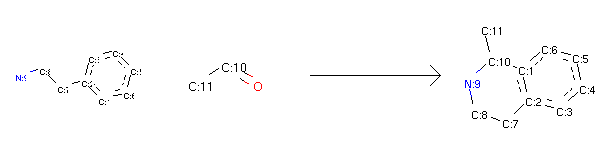

In [10]:
rxn = AllChem.ReactionFromSmarts('[cH1:1]1:[c:2](-[CH2:7]-[CH2:8]-[NH2:9]):[c:3]:[c:4]:[c:5]:[c:6]:1.'
                                 '[#6:11]-[CH1;R0:10]=[OD1]>>'
                                 '[c:1]12:[c:2](-[CH2:7]-[CH2:8]-[NH1:9]-[C:10]-2(-[#6:11])):[c:3]:[c:4]:[c:5]:[c:6]:1	')
rxn

Reactants:

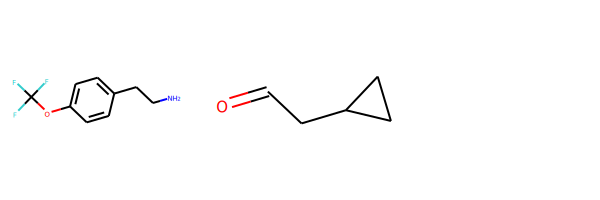

In [11]:
reactants = [Chem.MolFromSmiles(x) for x in ('c1cc(OC(F)(F)F)ccc1CCN','C1CC1CC=O')]
Draw.MolsToGridImage(reactants)

The products:

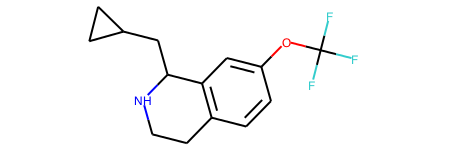

In [12]:
ps = rxn.RunReactants(reactants)
ps[0][0]

Ok, those were the basics that have been around for a while.

One of the new additions is `ChemicalReaction.RunReactant()`, this carries out whatever manipulations are required to process just one of the reaction's reactants and add it to the products:

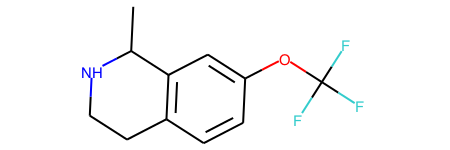

In [13]:
p0s = rxn.RunReactant(reactants[0],0)
p0s[0][0]

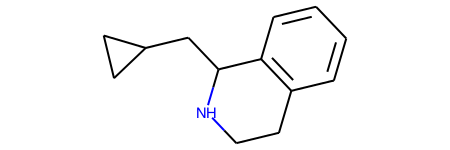

In [14]:
p1s = rxn.RunReactant(reactants[1],1)
p1s[0][0]

The molecules resulting from `ChemicalReaction.RunReactant()` carry some additional information that allow them to be reduced to just the part that is added to the product. This can be accessed with the function `ReduceProductToSideChains()`, which can either add a dummy to show where the attachment occurs:

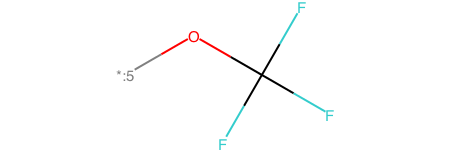

In [15]:
AllChem.ReduceProductToSideChains(p0s[0][0],addDummyAtoms=True)

The atom-map number on the dummy atom is the mapping number of the product atom it is connected to.

The dummy can also be left out:

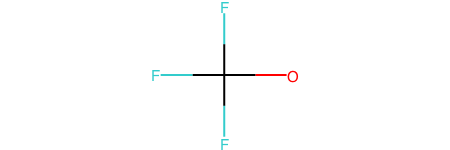

In [16]:
AllChem.ReduceProductToSideChains(p0s[0][0],addDummyAtoms=False)

Here's the same thing for the second reactant:

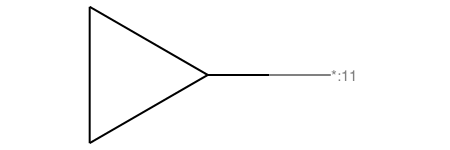

In [17]:
AllChem.ReduceProductToSideChains(p1s[0][0],addDummyAtoms=True)

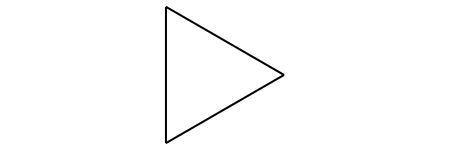

In [18]:
AllChem.ReduceProductToSideChains(p1s[0][0],addDummyAtoms=False)

You can also apply this function to the products of the full reaction:

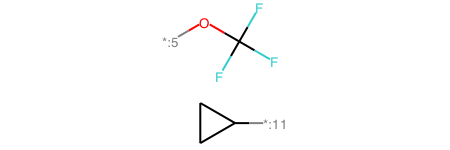

In [19]:
AllChem.ReduceProductToSideChains(ps[0][0],addDummyAtoms=True)

Let's look at another ring-forming reaction, the Friedlaender reaction:

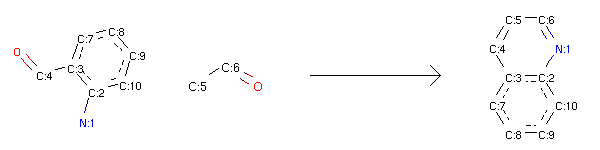

In [20]:
f_rxn2 = AllChem.ReactionFromSmarts('[NH2:1]-[c:2]1:[c:3](-[CH1:4]=[OD1])[c:7][c:8][c:9][c:10]1.'
                                    '[C;$(C([#6])[#6]):6](=[OD1])-[CH2;$(C([#6])[#6]);!$(C(C=O)C=O):5]>>'
                                    '[N:1]1-[c:2]2:[c:3](-[C:4]=[C:5]-[C:6]:1)[c:7][c:8][c:9][c:10]2')
f_rxn2

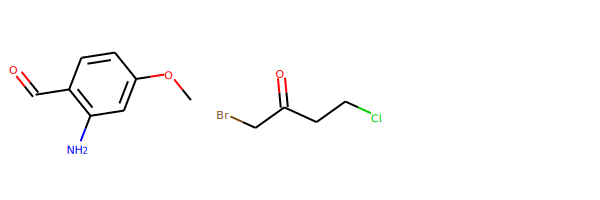

In [21]:
f_reactants = [Chem.MolFromSmiles(x) for x in ['Nc1c(C=O)ccc(OC)c1','ClCCC(=O)CBr']]
Draw.MolsToGridImage(f_reactants)

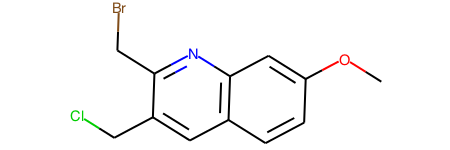

In [22]:
ps = f_rxn2.RunReactants(f_reactants)
ps[0][0]

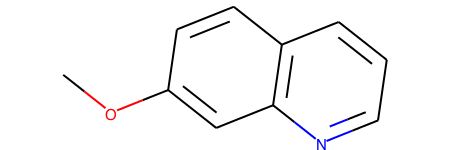

In [23]:
p0s = f_rxn2.RunReactant(f_reactants[0],0)
p0s[0][0]

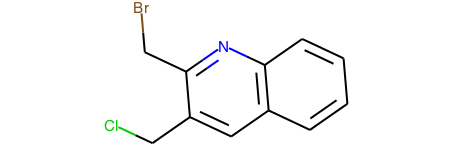

In [24]:
p1s = f_rxn2.RunReactant(f_reactants[1],1)
p1s[0][0]

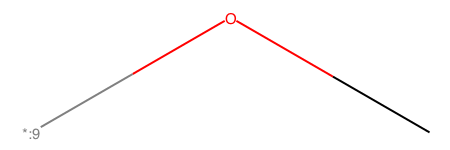

In [25]:
AllChem.ReduceProductToSideChains(p0s[0][0],addDummyAtoms=True)

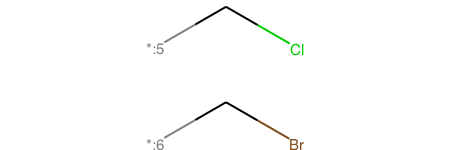

In [26]:
AllChem.ReduceProductToSideChains(p1s[0][0],addDummyAtoms=True)

## Tuning Substructure Queries



The same options are available from Python using the function `Chem.AdjustQueryProperties()`:

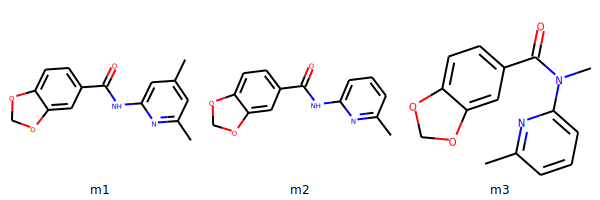

In [27]:
m1 = Chem.MolFromSmiles('Cc1cc(C)nc(NC(=O)c2ccc3c(c2)OCO3)c1')
m2 = Chem.MolFromSmiles('c1cc(C)nc(NC(=O)c2ccc3c(c2)OCO3)c1')
m3 = Chem.MolFromSmiles('c1cc(C)nc(N(C)C(=O)c2ccc3c(c2)OCO3)c1')
Draw.MolsToGridImage((m1,m2,m3),legends=['m1','m2','m3'])

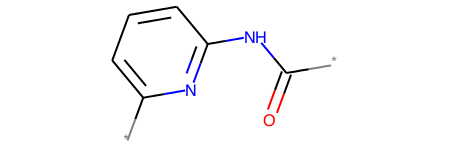

In [28]:
q = Chem.MolFromSmiles('*c1cccc(NC(=O)*)n1')
q

Initially this has no substructure matches since the dummy atoms can't match anything:

In [29]:
m1.HasSubstructMatch(q),m2.HasSubstructMatch(q),m3.HasSubstructMatch(q)

(False, False, False)

The defaults to `Chem.AdjustQueryProperties()` take care of this, but they also exclude the match to m1 due to the degree queries added to ring atoms:

In [30]:
tq = Chem.AdjustQueryProperties(q)
m1.HasSubstructMatch(tq),m2.HasSubstructMatch(tq),m3.HasSubstructMatch(tq)

(False, True, True)

Turn off the degree queries and all the molecules match:

In [31]:
params = Chem.AdjustQueryParameters()
params.adjustDegree=False
tq = Chem.AdjustQueryProperties(q,params)
m1.HasSubstructMatch(tq),m2.HasSubstructMatch(tq),m3.HasSubstructMatch(tq)

(True, True, True)

We can also use the degree query only on chain atoms, this disables the match of m3:

In [33]:
params = Chem.AdjustQueryParameters()
params.adjustDegree=True
params.adjustDegreeFlags=Chem.ADJUST_IGNORERINGS|Chem.ADJUST_IGNOREDUMMIES
tq = Chem.AdjustQueryProperties(q,params)
m1.HasSubstructMatch(tq),m2.HasSubstructMatch(tq),m3.HasSubstructMatch(tq)

(True, True, False)

This can also be used from inside the cartridge:

    select molregno,molfile from rdk.mols 
      join compound_structures using (molregno) 
      where m@>mol_adjust_query_properties('*c1cccc(*)n1') 
      limit 10 ;
        
You provide the parameters as JSON:

    select molregno,molfile from rdk.mols 
      join compound_structures using (molregno) 
      where m@>mol_adjust_query_properties('*c1cccc(*)n1',
                                           '{"adjustDegree":false}') 
      limit 10 ;
                                                         
    select molregno,molfile from rdk.mols
      join compound_structures using (molregno) 
      where m@>mol_adjust_query_properties('*c1cccc(NC(=O)*)n1',
                                           '{"adjustDegree":true,
                                             "adjustDegreeFlags":"IGNORERINGS|IGNOREDUMMIES"}')
      limit 10 ;

# Jupyter Interactivity

There actually isn't much new RDKit functionality here, but it's so cool that I can't help but show it.

## Browsing conformations

In [13]:
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
from ipywidgets import interact, interactive, fixed
def drawit(m,p,confId=-1):
        mb = Chem.MolToMolBlock(m,confId=confId)
        p.removeAllModels()
        p.addModel(mb,'sdf')
        p.setStyle({'stick':{}})
        p.setBackgroundColor('0xeeeeee')
        p.zoomTo()
        return p.show()

In [14]:
m = Chem.MolFromSmiles(r'COc1ccc2[nH]c([S@@+]([O-])Cc3ncc(C)c(OC)c3C)nc2c1') # esomeprazole

In [15]:
m = Chem.AddHs(m)
AllChem.EmbedMultipleConfs(m,numConfs=10,randomSeed=0xf00d,useExpTorsionAnglePrefs=True,\
                       useBasicKnowledge=True)
# align to one of the ring systems:
AllChem.AlignMolConformers(m,m.GetSubstructMatch(Chem.MolFromSmarts('c1[nH]c2ccccc2n1')))

# now construct the view and interactive widget:
p = py3Dmol.view(width=400,height=400)
interact(drawit, m=fixed(m),p=fixed(p),confId=(0,m.GetNumConformers()-1));

## Explaining fingerprint bits

In [3]:
from rdkit import Chem, DataStructs
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from rdkit.Avalon import pyAvalonTools
import pickle
from collections import defaultdict

from rdkit import rdBase
print(rdBase.rdkitVersion)

2016.09.1.dev1


In [4]:
# Start by importing some code to allow the depiction to be used:
from IPython.display import SVG,display
from ipywidgets import interact,fixed,IntSlider
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

def moltosvg(mol,molSize=(450,200),kekulize=True,drawer=None,**kwargs):
    mc = rdMolDraw2D.PrepareMolForDrawing(mol,kekulize=kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))
def highlightSubgraphs(mol,subgraphs):
    """ highlights bonds in a molecule 
        subgraphs is a sequence of sequences
    """
    hbonds = []
    bcs = {}
    colors=((1,.1,.1),(.1,.1,1),(1,.1,1), (1,1,.1), (.1,1,1))
    for i,sg in enumerate(subgraphs):
        hbonds.extend(sg)
        refColor = colors[i%(len(colors))]
        for b in sg: bcs[b]=refColor
    return moltosvg(mol,highlightAtoms=[],highlightBonds=hbonds,highlightBondColors=bcs)
def renderSubgraphs(mol,bitidx,bitInfo):
    itms = list(bitInfo.items())
    itms.sort(key=lambda x:(len(x[1][0]),len(x[1]),x[0]))
    bid,subgraphs = itms[bitidx]
    print("Bit:",bid)
    print("\t",subgraphs)
    return(display(highlightSubgraphs(mol,subgraphs)))
def renderSubgraphsBySize(mol,sz,bitidx,bi_by_size):
    entries = bi_by_size[sz]
    itms = [x for x in entries.items() if x[1]]
    # the individual items are ordered by the number of times they occur:
    itms.sort(key=lambda x:(len(x[1]),x[0]))
    bid,subgraphs = itms[bitidx]
    print("Bit:",bid)
    print("\t",subgraphs)
    return(display(highlightSubgraphs(mol,subgraphs)))


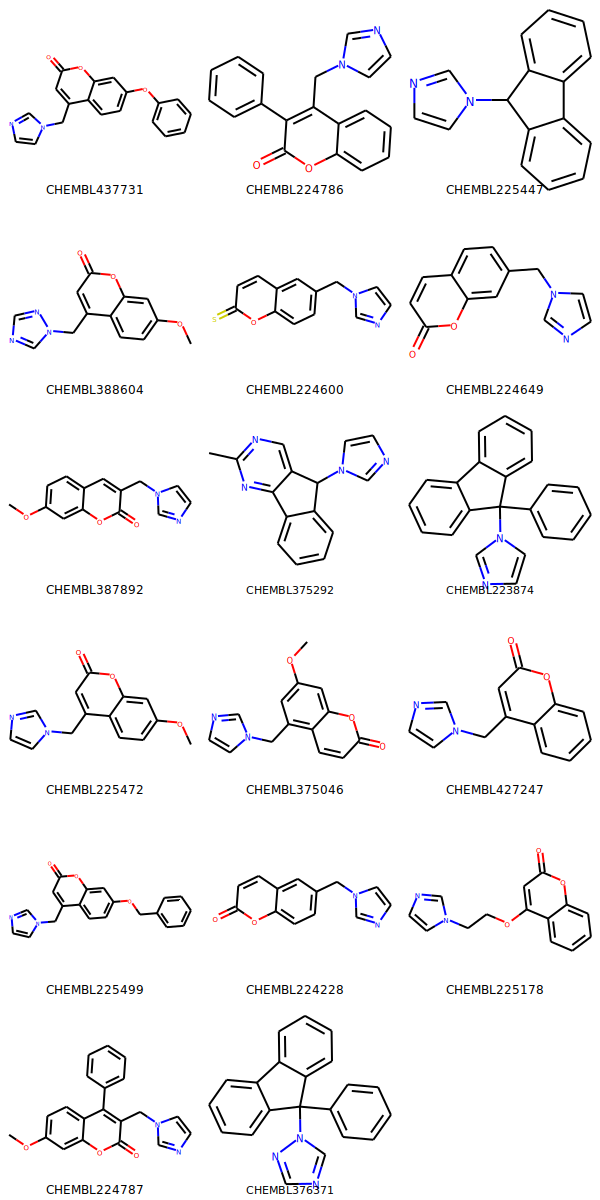

In [5]:
d = pickle.load(open('./data/Target_no_65.pkl','rb'))  # this particular target is "Cytochrome P450 19A1 Homo sapiens"
entries = d[35328]
mols = [Chem.MolFromSmiles(y) for x,y in entries]
nms = [x for x,y in entries]
Draw.MolsToGridImage(mols,legends=nms)

### Start with RDKit fingerprint bits:

Bit: 1023
	 [[0, 1, 2, 9, 18, 15]]


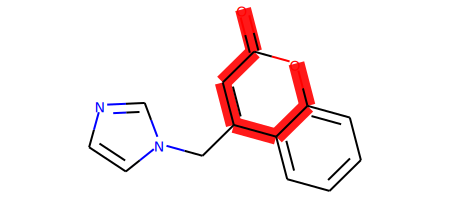

In [6]:
m1= mols[11]
bitInfo={}
fp1 = Chem.RDKFingerprint(m1,nBitsPerHash=1,bitInfo=bitInfo)
# organize the bit info by size:
bi_by_size = defaultdict(lambda : defaultdict(list))
for k,sgs in bitInfo.items():
    for sg in sgs:
        bi_by_size[len(sg)][k].append(sg)
sz_widget = IntSlider(min=min(bi_by_size.keys()), max=max(bi_by_size.keys()),step=1,value=1,description="Path Size")
bit_widget = IntSlider(min=0,max=10,description="Example")

def update_bit_range(change):
    bit_widget.max = len([x for x in bi_by_size[change['new']].items() if x[1]])-1
    bit_widget.value=min(bit_widget.max,bit_widget.value)
sz_widget.observe(update_bit_range, names='value')
update_bit_range(dict(new=sz_widget.value))
interact(renderSubgraphsBySize, sz=sz_widget, bitidx=bit_widget, mol=fixed(m1),bi_by_size=fixed(bi_by_size));

### Morgan fingerprints

In [7]:
# do a depiction where the atom environment is highlighted normally and the central atom
# is highlighted in blue
def getMorganSubstructDepiction(mol,atomID,radius,molSize=(450,200)):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))       
    else:
        atomsToUse = [atomID]
        env=None
    return moltosvg(mol,molSize=molSize,highlightAtoms=atomsToUse,highlightAtomColors={atomID:(0.3,0.3,1)})
def renderMorganByRadius(mol,rad,bitidx,mfp_data):
    entries = list(mfp_data[rad])
    # the individual items are ordered by the bit id
    entries.sort()
    bitid,aid = entries[bitidx]
    print("Bit:",bitid)
    return(display(getMorganSubstructDepiction(mol,aid,rad)))


In [8]:
m1= mols[11]
bi3 = {}
fp3 = rdMolDescriptors.GetMorganFingerprint(m1,3,bitInfo=bi3)
itms3 = list(bi3.items())
# organize by radius:
mfp_data = defaultdict(list)
for bid,seq in itms3:
    for aid,rad in seq:
        mfp_data[rad].append((bid,aid))

Bit: 2089117413


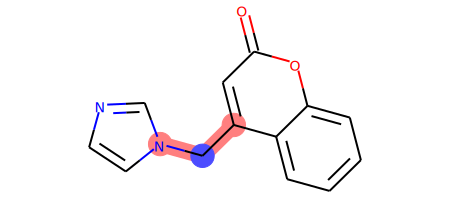

In [9]:
rad_widget = IntSlider(min=0, max=3,step=1,value=2,description="Radius")
mbit_widget = IntSlider(min=0,max=10,description="Example")

def update_mbit_range(change):
    mbit_widget.max = len(mfp_data[change['new']])-1
    mbit_widget.value=min(mbit_widget.max,mbit_widget.value)
rad_widget.observe(update_mbit_range, names='value')
update_mbit_range(dict(new=rad_widget.value))
interact(renderMorganByRadius, rad=rad_widget, bitidx=mbit_widget, mol=fixed(m1),mfp_data=fixed(mfp_data));

In [44]:
# don't want the rendering as the last element in the notebook:
itms3

[(349255488, ((1, 3),)),
 (864942730, ((0, 0),)),
 (2036422670, ((1, 2),)),
 (368713488, ((15, 1),)),
 (2300224530, ((4, 3),)),
 (3748530068, ((15, 3),)),
 (1019486874, ((10, 3),)),
 (3999906991, ((12, 2), (13, 2))),
 (2900621984, ((3, 3),)),
 (2759434019, ((1, 1),)),
 (540046244, ((9, 1),)),
 (1313967653, ((11, 2),)),
 (2092489639, ((5, 0),)),
 (3928365, ((13, 3),)),
 (2761542830, ((14, 3),)),
 (2991151069, ((12, 3),)),
 (2242263733, ((5, 3),)),
 (2053123511, ((6, 2),)),
 (197391800, ((6, 3),)),
 (10565946, ((0, 1),)),
 (536217482, ((4, 2),)),
 (2036869822, ((5, 2),)),
 (30373559, ((7, 3),)),
 (98513984, ((12, 1), (13, 1))),
 (3118255683, ((8, 1),)),
 (4197146180, ((16, 1),)),
 (4089138501, ((3, 1),)),
 (3776905034, ((7, 1),)),
 (2910395211, ((8, 2),)),
 (571978829, ((6, 1),)),
 (3983062349, ((10, 1),)),
 (2245384272, ((4, 0),)),
 (3218693969,
  ((2, 0), (6, 0), (7, 0), (9, 0), (11, 0), (12, 0), (13, 0), (14, 0))),
 (13251412, ((16, 2),)),
 (951226070, ((11, 1), (14, 1))),
 (143754876